In [ ]:
#import all the necessary libraries and modules
import pandas as pd
import numpy as np
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
import keras
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import precision_recall_curve
from funcsigs import signature
from keras.preprocessing.text import Tokenizer
import seaborn as sns
import time
import os
import matplotlib.pyplot as plt
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]="1"
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import table

In [2]:
data = pd.read_csv('Dataset/smart_contracts_op_codes.csv') # importing dataset
data.columns=['smart_contract_address', 'op_code', 'vulnerability']
data.head()

,smart_contract_address,op_code,vulnerability
0,0x219f4ee903f78e78773e5d1e3520cfd507485bc6,60 60 52 36 15 61 57 60 35 7c 90 04 63 16 80 6...,1 0 0 0
1,0x560ed796aa8d23411b94b9d047ecdda39d4fcdeb,60 60 52 36 15 61 57 60 35 7c 90 04 63 16 80 6...,1 0 0 0
2,0xe726f97ff3c63dd71c1520c102adc39d1a2693ea,60 60 52 36 15 61 57 60 35 7c 90 04 63 16 80 6...,1 0 0 0
3,0x8ebac490495958b3804bb079e259340f0f53b69c,60 60 52 36 15 61 57 60 35 7c 90 04 63 16 80 6...,1 0 0 0
4,0x190700d69031db6b072a30577f9b3dbc53a320a1,60 60 52 36 15 61 57 60 35 7c 90 04 63 16 80 6...,1 0 0 0


In [3]:
data.shape

(892913, 3)

In [4]:
# splitting the dataset into different types of vulnerabilities
vcs=pd.value_counts(data['vulnerability'])
labels1=vcs.index
v0=data[data['vulnerability'] == labels1[0]]
v1=data[data['vulnerability'] == labels1[1]]
v2=data[data['vulnerability'] == labels1[2]]
v3=data[data['vulnerability'] == labels1[3]]
v4=data[data['vulnerability'] == labels1[4]]

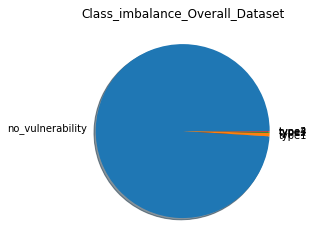

In [5]:
# showing class imbalance
# here, samples with vulnerabilities << samples without vulnerabilities
# so, in order to balance the class, we drop excess samples without vulnerabilities
sample_labels = np.array([v0.shape[0],v1.shape[0],v2.shape[0],v3.shape[0],v4.shape[0]])
mylabels = ["no_vulnerability", "type1", "type2", "type3","type4"]
plt.pie(sample_labels,shadow=True,labels=mylabels)
plt.title('Class_imbalance_Overall_Dataset')
plt.show()

In [6]:
# combining all samples with vulnerabilities into one dataset
positive_samples=pd.concat([v1,v2,v3,v4],axis=0)
positive_sample_size=positive_samples.shape
negative_samples=v0.sample(positive_sample_size[0])
negative_sample_size=negative_samples.shape

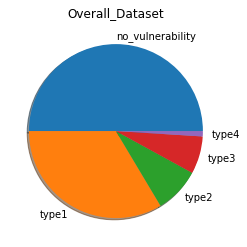

In [7]:
# after dropping excess samples without vulnerability
sample_labels = np.array([negative_samples.shape[0],v1.shape[0],v2.shape[0],v3.shape[0],v4.shape[0]])
mylabels = ["no_vulnerability", "type1", "type2", "type3","type4"]
plt.pie(sample_labels,shadow=True,labels=mylabels)
plt.title('Overall_Dataset')
plt.show() 

In [8]:
# conversion of op code to sequence of number using tokenization # NLP
def preprocess(df):
    n_most_common_words = 1000 
    max_len = 130
    tokenizer = Tokenizer(num_words=n_most_common_words, lower=False)
    tokenizer.fit_on_texts(df['op_code'].values)
    sequences = tokenizer.texts_to_sequences(df['op_code'].values)
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))
    X = pad_sequences(sequences, maxlen=max_len)
    return X

In [9]:
preprocessed_positive_samples=preprocess(positive_samples)
preprocessed_negative_samples=preprocess(negative_samples)
X_not_pp=pd.concat([positive_samples,negative_samples],axis=0)
X=preprocess(X_not_pp)
X_not_pp.shape

Found 150 unique tokens.
Found 150 unique tokens.
Found 150 unique tokens.


(17280, 3)

In [10]:
X_not_pp

,smart_contract_address,op_code,vulnerability
1483,0x3e72c21f50170a76149dce9b8ba1eccbd5973ac7,60 60 52 36 15 61 57 60 35 7c 90 04 63 16 80 6...,0 0 0 1
1849,0x78530704aa62a96f6e2f20fb4621ea740fb18dcc,60 60 52 36 15 61 57 60 35 7c 90 04 63 16 80 6...,0 0 0 1
2442,0x4574ff7d8e558ae89ce179abfac16f44eca1d493,60 60 52 36 15 60 57 60 56 5b 60 5b 7f 60 51 8...,0 0 0 1
2443,0xbcb3cb6f0a281bff6871fef0833b2e1d723dd47c,60 60 52 36 15 60 57 60 56 5b 60 5b 7f 60 51 8...,0 0 0 1
2483,0x43b8a55e1142cadba4f08ae0a382bd409a90733a,60 60 52 36 15 61 57 60 60 0a 60 35 04 63 81 1...,0 0 0 1
...,...,...,...
370638,0x1f128f76a5f844021861837376105e9cb6b73b01,60 60 52 36 15 61 57 60 35 7c 90 04 63 16 80 6...,1 0 0 0
532142,0xa86af9aaf2cdced702c53482731fdb923635b4e9,60 60 52 36 15 61 57 63 7c 60 35 04 16 63 81 1...,1 0 0 0
510307,0x597f5397e8bd2624eacb9f9662cf708d5d4ffc78,60 60 52 36 15 61 57 60 35 7c 90 04 63 16 80 6...,1 0 0 0
632555,0x2c14d72b45541c32e5dae4503aeda9e12a27fa73,60 60 52 5b 5b 73 30 73 16 31 80 15 61 02 90 6...,1 0 0 0


In [11]:
# splitting of dataset into train,val and test dataset 
y1_positive=positive_samples.vulnerability
X1_positive=positive_samples.drop(['vulnerability'],axis=1)
X_train_positive, X2_positive, y_train_positive, y2_positive = train_test_split(X1_positive, y1_positive, train_size=0.64)
X_test_positive,X_val_positive,y_test_positive,y_val_positive=train_test_split(X2_positive,y2_positive,train_size=.5)

y1_negative=negative_samples.vulnerability
X1_negative=negative_samples.drop(['vulnerability'],axis=1)
X_train_negative, X2_negative, y_train_negative, y2_negative = train_test_split(X1_negative, y1_negative, train_size=0.7)
X_test_negative,X_val_negative,y_test_negative,y_val_negative=train_test_split(X2_negative,y2_negative,train_size=.56)


In [12]:
y_test_positive.value_counts()

0 0 0 1    1080
0 0 1 0     256
0 1 0 0     190
0 1 1 0      29
Name: vulnerability, dtype: int64

In [13]:
y_tsp=y_test_positive.index
for i in y_tsp:
    y_test_positive[i]=1
y_trp=y_train_positive.index
for i in y_trp:
    y_train_positive[i]=1
y_tvp=y_val_positive.index
for i in y_tvp:
    y_val_positive[i]=1
y_tsn=y_test_negative.index
for i in y_tsn:
    y_test_negative[i]=0
y_trn=y_train_negative.index
for i in y_trn:
    y_train_negative[i]=0
y_tvn=y_val_negative.index
for i in y_tvn:
    y_val_negative[i]=0

In [14]:
print('X_train_positive',X_train_positive.shape)
print('X_test_positive',X_test_positive.shape)
print('X_val_positive',X_val_positive.shape)
print('y_train_positive',y_train_positive.shape)
print('y_test_positive',y_test_positive.shape)
print('y_val_positive',y_val_positive.shape)

X_train_positive (5529, 2)
X_test_positive (1555, 2)
X_val_positive (1556, 2)
y_train_positive (5529,)
y_test_positive (1555,)
y_val_positive (1556,)


In [15]:
print('X_train_negative',X_train_negative.shape)
print('X_test_negative',X_test_negative.shape)
print('X_val_negative',X_val_negative.shape)
print('y_train_negative',y_train_negative.shape)
print('y_test_negative',y_test_negative.shape)
print('y_val_negative',y_val_negative.shape)

X_train_negative (6048, 2)
X_test_negative (1451, 2)
X_val_negative (1141, 2)
y_train_negative (6048,)
y_test_negative (1451,)
y_val_negative (1141,)


In [16]:
y_train_positive=pd.DataFrame(y_train_positive)
y_train_negative=pd.DataFrame(y_train_negative)
y_test_positive=pd.DataFrame(y_test_positive)
y_val_positive=pd.DataFrame(y_val_positive)
y_test_negative=pd.DataFrame(y_test_negative)
y_val_negative=pd.DataFrame(y_val_negative)

In [17]:
# combining dataset (positive and negative )
X_train=pd.concat([X_train_negative,X_train_positive],axis=0)
X_val=pd.concat([X_val_negative,X_val_positive],axis=0)
X_test=pd.concat([X_test_negative,X_test_positive],axis=0)
y_train=pd.concat([y_train_negative,y_train_positive],axis=0)
y_val=pd.concat([y_val_negative,y_val_positive],axis=0)
y_test=pd.concat([y_test_negative,y_test_positive],axis=0)

In [18]:
X_train=preprocess(X_train)
X_val=preprocess(X_val)
X_test=preprocess(X_test)

Found 150 unique tokens.
Found 150 unique tokens.
Found 150 unique tokens.


In [19]:
y_train=y_train.vulnerability
y_test=y_test.vulnerability
y_val=y_val.vulnerability

In [20]:
y_train_cat = to_categorical(y_train, num_classes=2)
y_val_cat = to_categorical(y_val, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)

In [ ]:
# training of the parameter in network 
keras.backend.clear_session()
n_most_common_words = 1000 
model = Sequential()
model.add(Embedding(n_most_common_words, 128, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.6))
model.add(LSTM(64, dropout=0.6, recurrent_dropout=0.6))
model.add(Dense(2, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())
start_time = time.time()
history = model.fit(X_train, y_train_cat, epochs=10, batch_size=256, validation_split=0.0, validation_data=(X_val, y_val_cat),callbacks=[EarlyStopping(monitor='loss',patience=7, min_delta=0.0001)])
end_time = time.time()
print('Time taken for training: ', end_time-start_time)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 130, 128)          128000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 130, 128)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
Total params: 177,538
Trainable params: 177,538
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
19/46 [===========>..................] - ETA: 40s - loss: 0.6253 - acc: 0.7469

In [ ]:
y_predicted = model.predict(X_test, batch_size=32, verbose=1)
y_test = np.array(y_test)
arr = np.array(range(0,len(y_test),1))
for i in range(0,len(y_test),1):
    if(y_predicted[i][0]<y_predicted[i][1]):
        arr[i]=1
    else:
        arr[i]=0
y_predicted=arr

In [ ]:
# other performance parameter evaluation
TP=0
TN=0
FP=0
FN=0
for i in range(0,len(y_predicted),1):
    if(y_test[i]==0):
        if(y_predicted[i]==0):
            TN+=1
        else:
            FP+=1
    else:
        if(y_predicted[i]==1):
            TP+=1
        else:
            FN+=1
print("true positives = ", TP)
print("false positives = ", FP)
print("true negatives = ", TN)
print("false negatives = ", FN)

In [ ]:
TPR=TP/(TP+FN)
FPR=FP/(FP+TN)
TNR=TN/(TN+FP)
FNR=FN/(FN+TP)
P=TP/(TP+FP)
R=TP/(TP+FN)
F1_score=2*P*R/(P+R)
print("Precision = ",P)
print("Recall = ",R)
print("F1-score = ",F1_score)

In [ ]:
print('False negative rate = ',FN/(FN+TP)*100,'%')
print('True positive rate',TP/(TP+FN)*100,'%')